# Evaluate models trained in other notebook:

## Setting up:
### Additional installations

In [1]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip install -U -q PyDrive
! pip uninstall shapely
! pip install shapely --no-binary shapely

     |████████████████████████████████| 10.8 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 38.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 36.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 51.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 3.0 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516313 sha256=73a4ba0bff292ffde28b0d58ce66c6162a8de7a1b6d87d41a647239f3cd72e18
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy
     |███

### Imports:

In [3]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth
from google.colab import files

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up CUDA:

In [4]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? False
CUDA version: 11.3


### Helper scripts:

In [5]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *
from metrics import *
# Import custom scripts
#sys.path.append('../')
#from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:

In [6]:
"""
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt"""

"\nauth.authenticate_user()\n# Give our project ID\nproject_id = 'ee-iceshelf-gee4geo'\n!gcloud config set project {project_id}\n# Download the file from a given Google Cloud Storage bucket.\n!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt\n# Print the result to make sure the transfer worked.\n!cat /tmp/gsutil_download.txt"

### Set up Google Drive:

In [7]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Googledrive = GoogleDrive(gauth)

## Load data:

### (Input) Global climate model:

In [8]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    linkGCMLike = 'https://drive.google.com/file/d/1AVOnOqvV9YPiJTPoPWHWu3uk7293dqAo/view?usp=sharing'
    idGCMLike = '1AVOnOqvV9YPiJTPoPWHWu3uk7293dqAo'
    downloaded = Googledrive.CreateFile({'id':idGCMLike}) 
    downloaded.GetContentFile(fileGCMLike)  
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
print(GCMLike.dims)
GCMLike

Frozen(SortedKeysDict({'x': 90, 'y': 25, 'time': 1452}))
CPU times: user 2.3 s, sys: 498 ms, total: 2.8 s
Wall time: 7.73 s


### (Target) Regional climate model:

In [9]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    linkTarget = 'https://drive.google.com/file/d/15Kd81r9k6SA-1gTnpNZqBf4snl1UksbI/view?usp=sharing'
    idTarget = '15Kd81r9k6SA-1gTnpNZqBf4snl1UksbI'
    downloaded = Googledrive.CreateFile({'id':idTarget}) 
    downloaded.GetContentFile(fileTarget) 
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 176, 'PLEV': 7}))
New target dimensions: Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 160, 'PLEV': 7}))
CPU times: user 31.2 s, sys: 7.39 s, total: 38.6 s
Wall time: 2min 6s


In [10]:
target_dataset

<xarray.Dataset>
Dimensions:      (PLEV: 7, time: 1452, x: 160, y: 148)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.8e+06 -2.765e+06 ... 2.73e+06 2.765e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
Data variables:
    RF           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SP           (time, y, x) float32 999.8 999.6 999.5 ... 985.7 985.9 986.2
    LWD          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWD          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TT           (time, y, x) float32 5.735 5.514 5.299 ... 3.045 3.182 3.328
    SMB          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVP          (time, y, x) float64 6.066 5.686 5.358 ... -5.0 -5.258 -5.475
    UUP          (time, y, x) float64 -2.094 -1.85 -1.73 ... 4.135 4.28 4.378
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 10:47:19 2022: ncap2 -O -s RF=...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

# Scenario 1: evaluation on RCM

## Larsen:

In [11]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *
from metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
REGION = "Larsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss = 'MSE', 
    typeNet = TYPENET
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = False,
    **trainingParam
)

loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, **loader_args)

# Load saved model
today = str(date.today())
#today = '2022-05-10'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}_{TYPENET}.pth"
downloadModel = True
if downloadModel:
    #downloadFileFromGC(pathModel, "", model)
    # Download from google drive
    if TYPENET == 'Variance':
      print('Loading from variance model')
      idModel = '16p13IWZJ-CkyeFPS_5XVJTM8y3W_R2nh'
    elif TYPENET == 'Baseline':
      print('Loading from baseline model')
      idModel = '1sqfaj7ZG2rFogAIan9dTZXO-7OEaWY0B'
    downloaded = Googledrive.CreateFile({'id':idModel}) 
    downloaded.GetContentFile(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Larsen, x_Larsen, z_Larsen, true_smb_Larsen, r_Larsen = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Variance model
INFO: Network:
	14 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307



X shape: torch.Size([1452, 14, 32, 32])
Loading from variance model


INFO: Loading saved model MODEL_2022-05-11_Larsen_100_32_Variance.pth
INFO: Using device cpu
INFO: Saved model loaded!


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

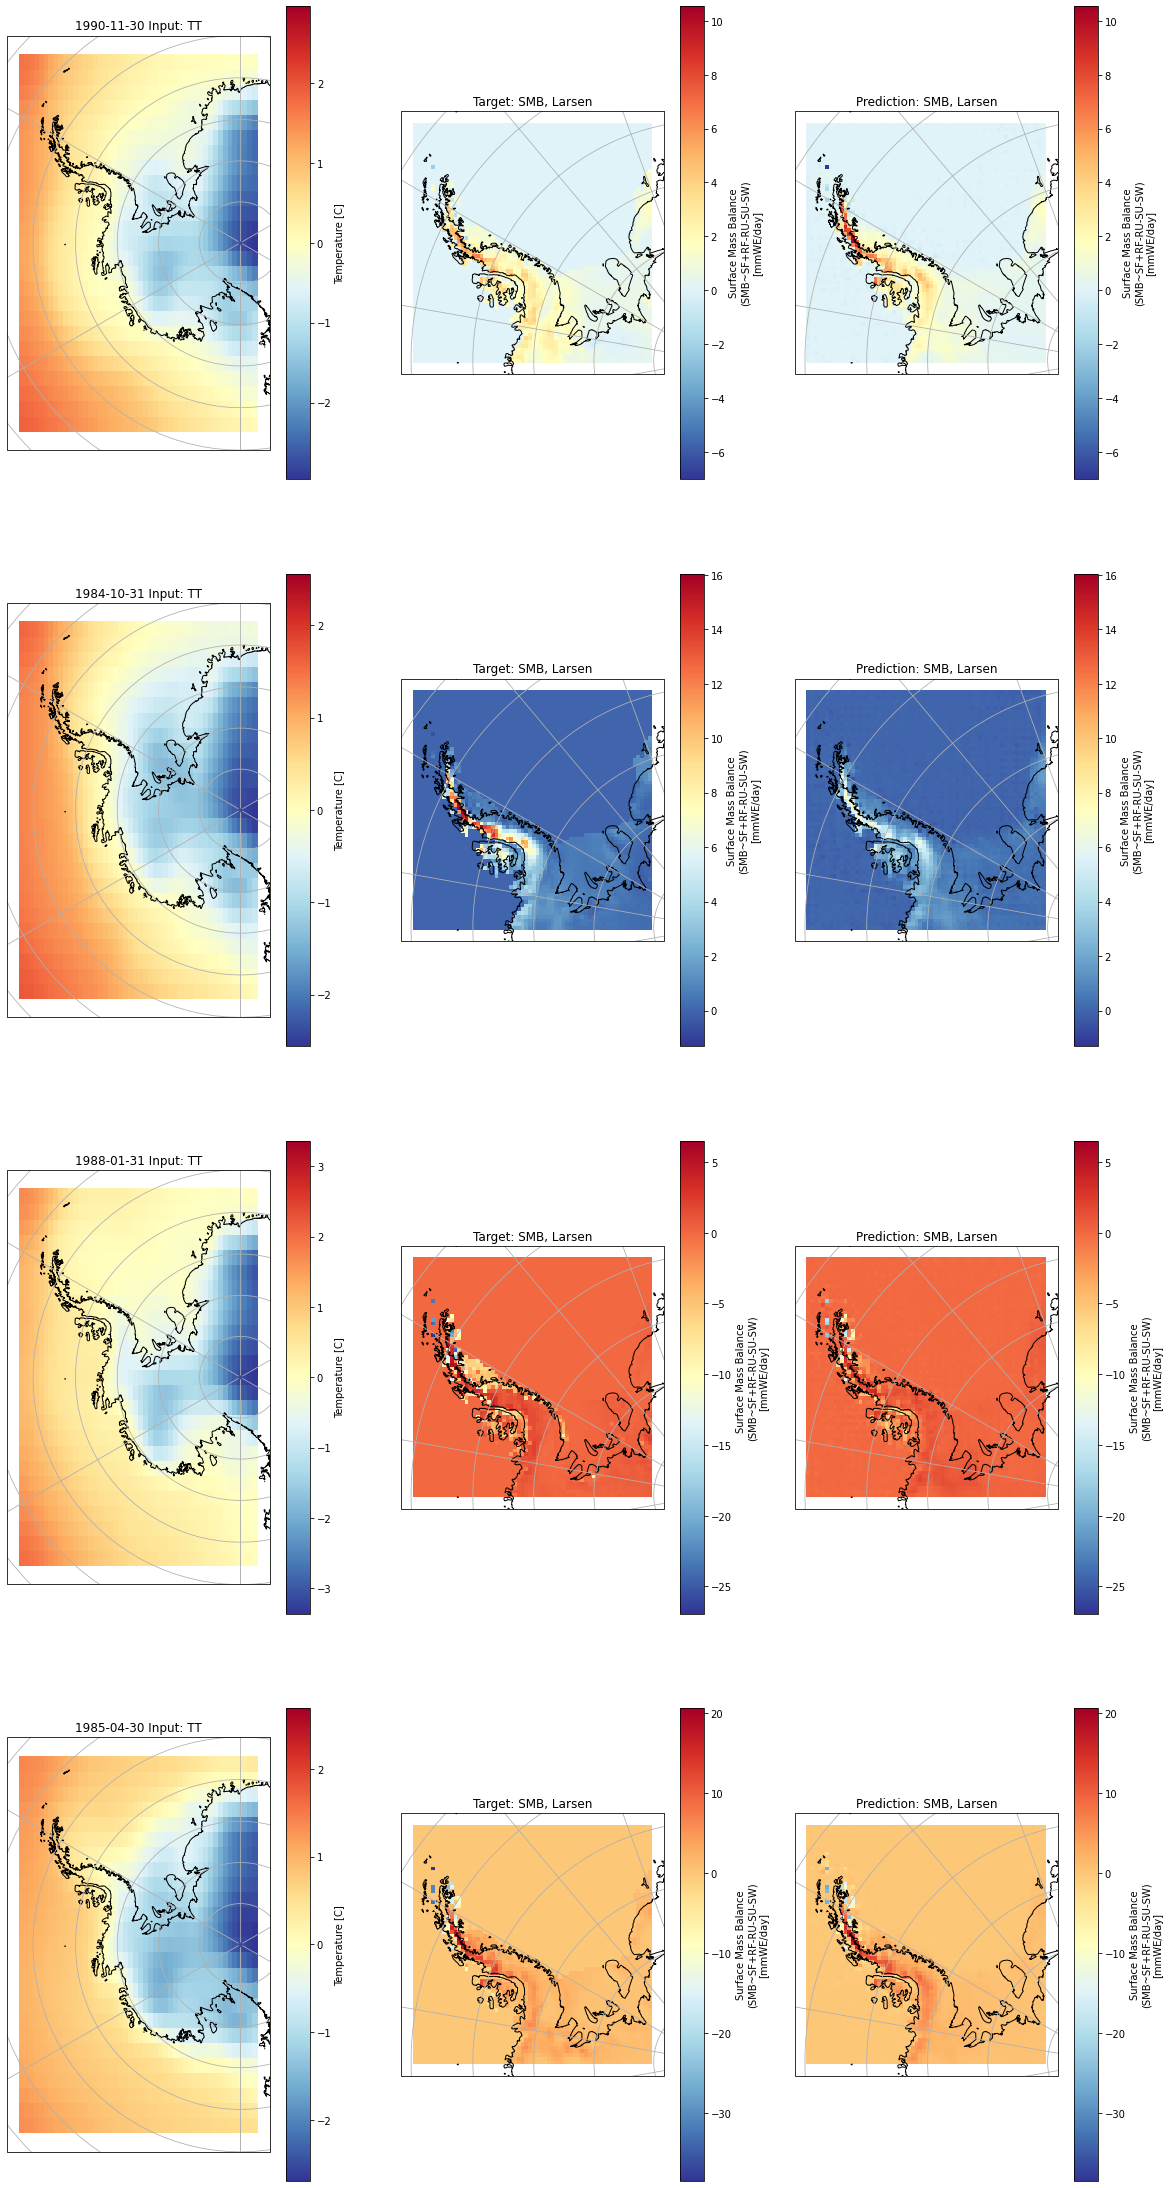

In [13]:
# plot predictions
f = plt.figure(figsize=(20, 40))

plotRandomPredictions(
    preds_Larsen,
    x_Larsen,
    z_Larsen,
    true_smb_Larsen,
    r_Larsen,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION]
)
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)

### Metrics:

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

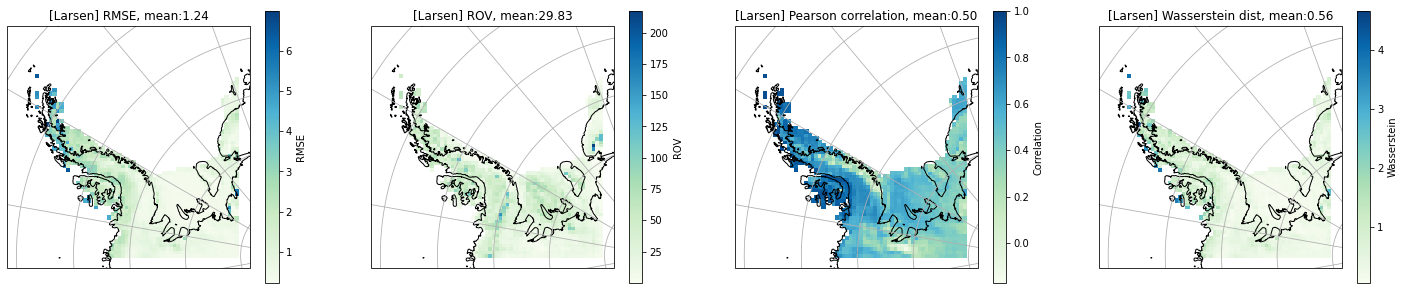

In [17]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Larsen, true_smb_Larsen, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)

### Random points:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


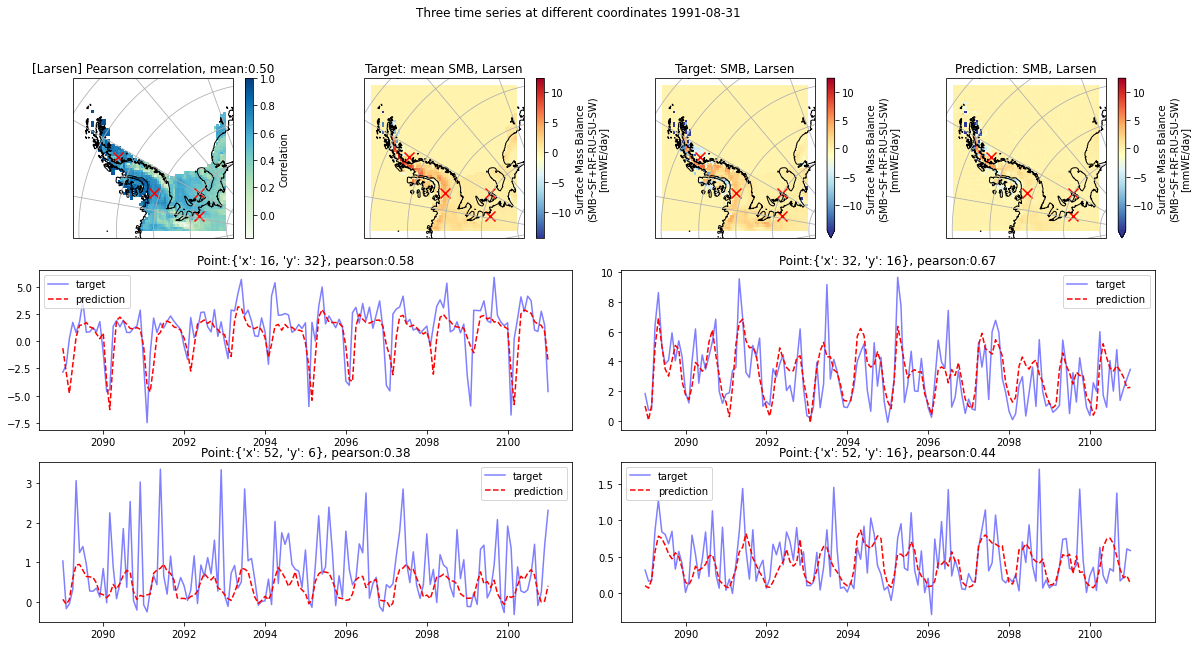

In [18]:
# plot points
points= ({'x':16, 'y':32},{'x':32, 'y':16}, {'x':52, 'y':6}, {'x':52, 'y':16})
randomPoints(points, PearsonCorr, true_smb_Larsen, preds_Larsen, target_dataset, GCMLike, train_set, REGION)
nameFig = '{}_ts_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)

## Maud:

In [ ]:
REGION = "Maud"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss = 'MSE', 
    typeNet = 'Variance'
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = False,
    **trainingParam
)

loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, **loader_args)

# Load saved model
today = str(date.today())
#today = '2022-05-03'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    #downloadFileFromGC(pathModel, "", model)
    # Download from google drive
    idModel = '1-97LdyuuVAiM69Avb_HbkAfjGNh8pLPB'
    downloaded = Googledrive.CreateFile({'id':idModel}) 
    downloaded.GetContentFile(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Maud, x_Maud, z_Maud, true_smb_Maud, r_Maud = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Variance model
INFO: Network:
	14 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307



X shape: torch.Size([1452, 14, 32, 32])


INFO: Loading saved model MODEL_2022-05-11_Maud_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

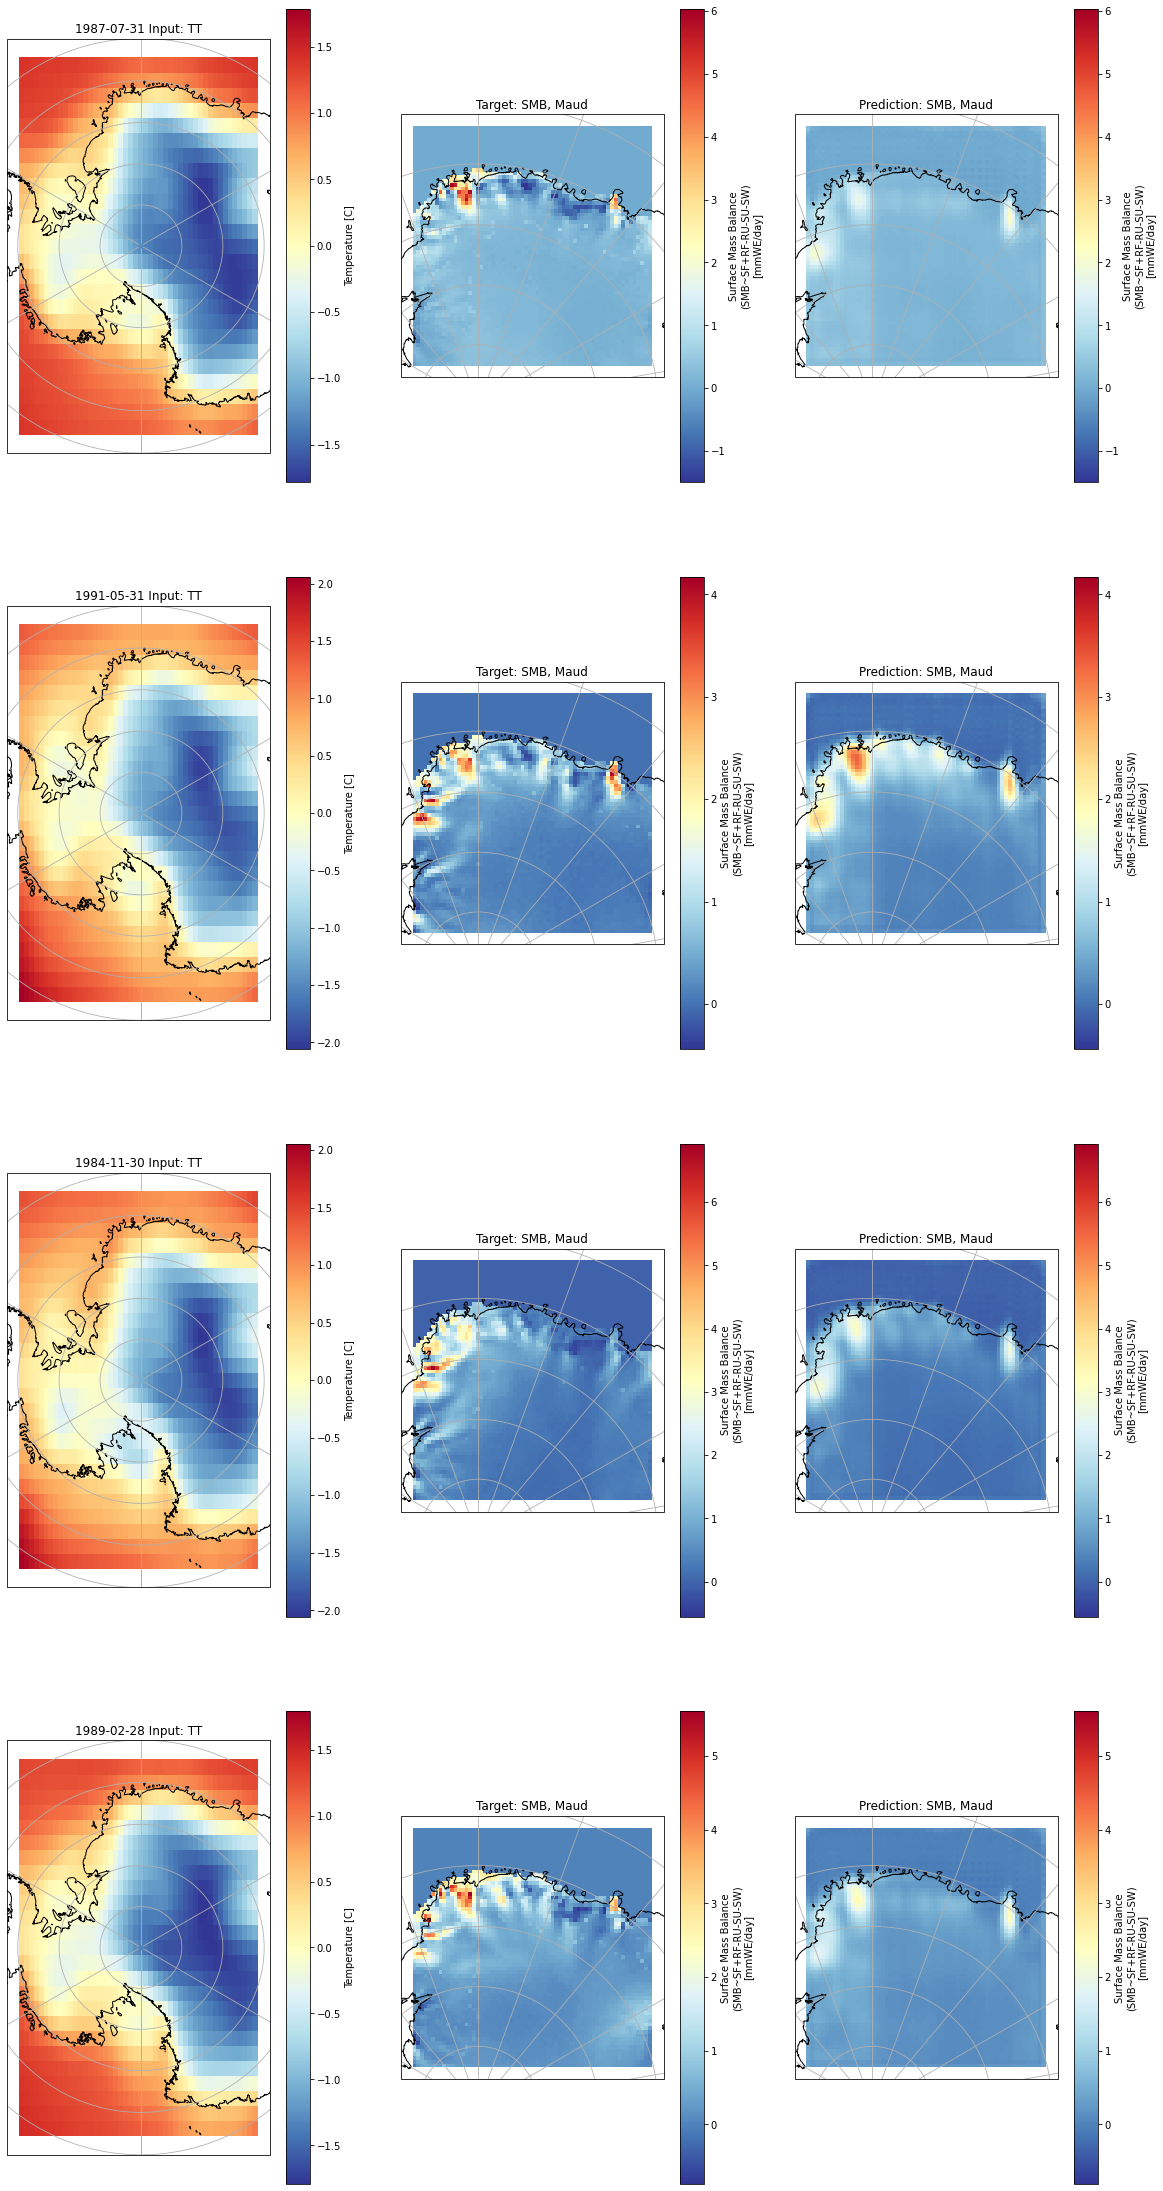

In [ ]:
# plot predictions
f = plt.figure(figsize=(20, 40))

plotRandomPredictions(
    preds_Maud,
    x_Maud,
    z_Maud,
    true_smb_Maud,
    r_Maud,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION]
)
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)

### Metrics:

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

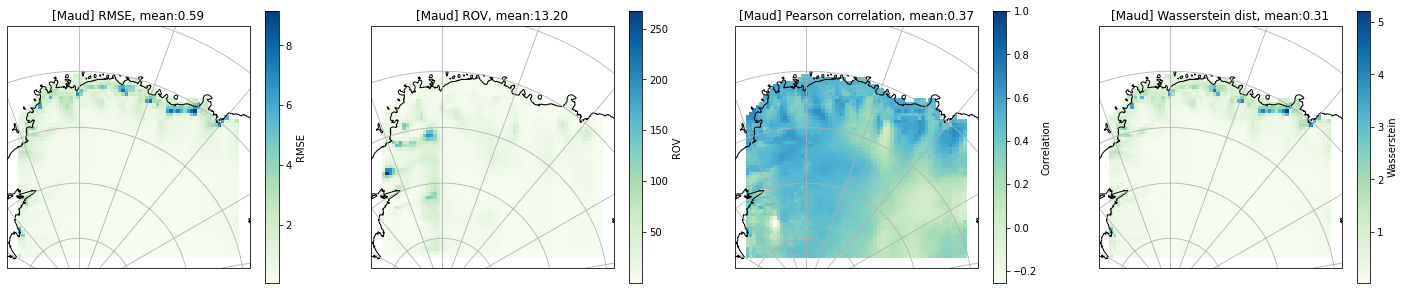

In [ ]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Maud, true_smb_Maud, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)

### Random points:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


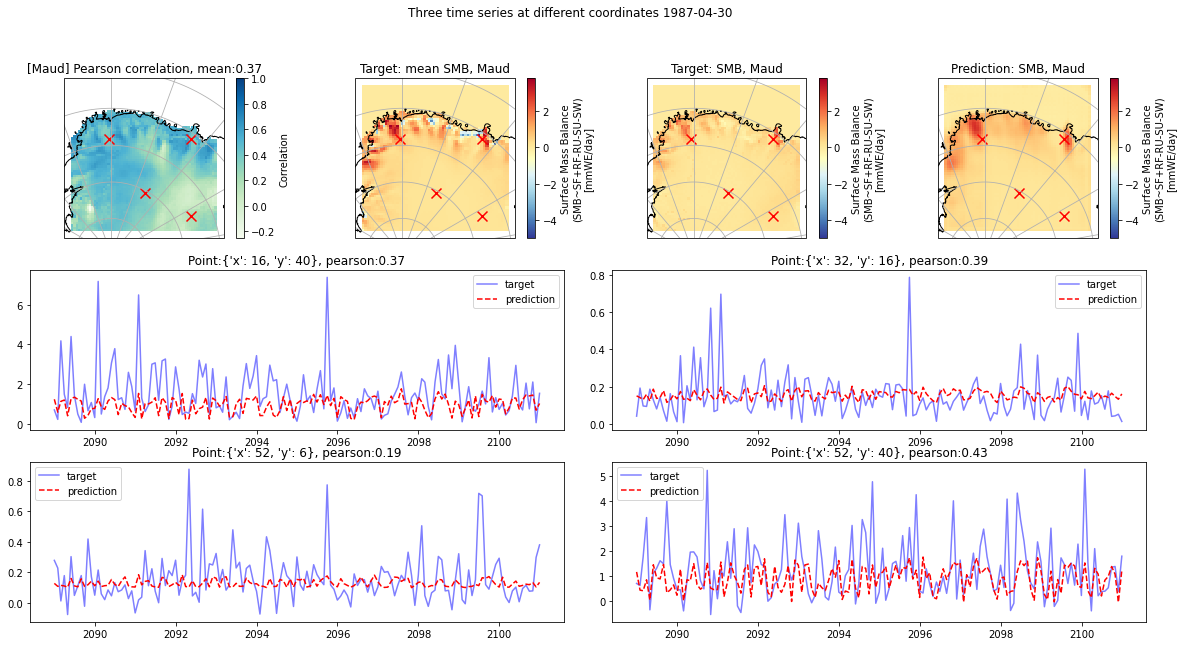

In [ ]:
# plot points
points= ({'x':16, 'y':40},{'x':32, 'y':16}, {'x':52, 'y':6}, {'x':52, 'y':40})
randomPoints(points, PearsonCorr, true_smb_Maud, preds_Maud, target_dataset, GCMLike, train_set, REGION)
nameFig = '{}_ts_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)

## Wilkes:

In [ ]:
REGION = "Wilkes"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss = 'MSE', 
    typeNet = 'Variance'
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = False,
    **trainingParam
)

loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, **loader_args)

# Load saved model
today = str(date.today())
#today = '2022-05-03'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    #downloadFileFromGC(pathModel, "", model)
    # Download from google drive
    idModel = '1-D9Dz95wzpyJr7vimX4kaASEF2ODvZVv'
    downloaded = Googledrive.CreateFile({'id':idModel}) 
    downloaded.GetContentFile(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Wilkes, x_Wilkes, z_Wilkes, true_smb_Wilkes, r_Wilkes = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Variance model
INFO: Network:
	14 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307



X shape: torch.Size([1452, 14, 32, 32])


INFO: Loading saved model MODEL_2022-05-11_Wilkes_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

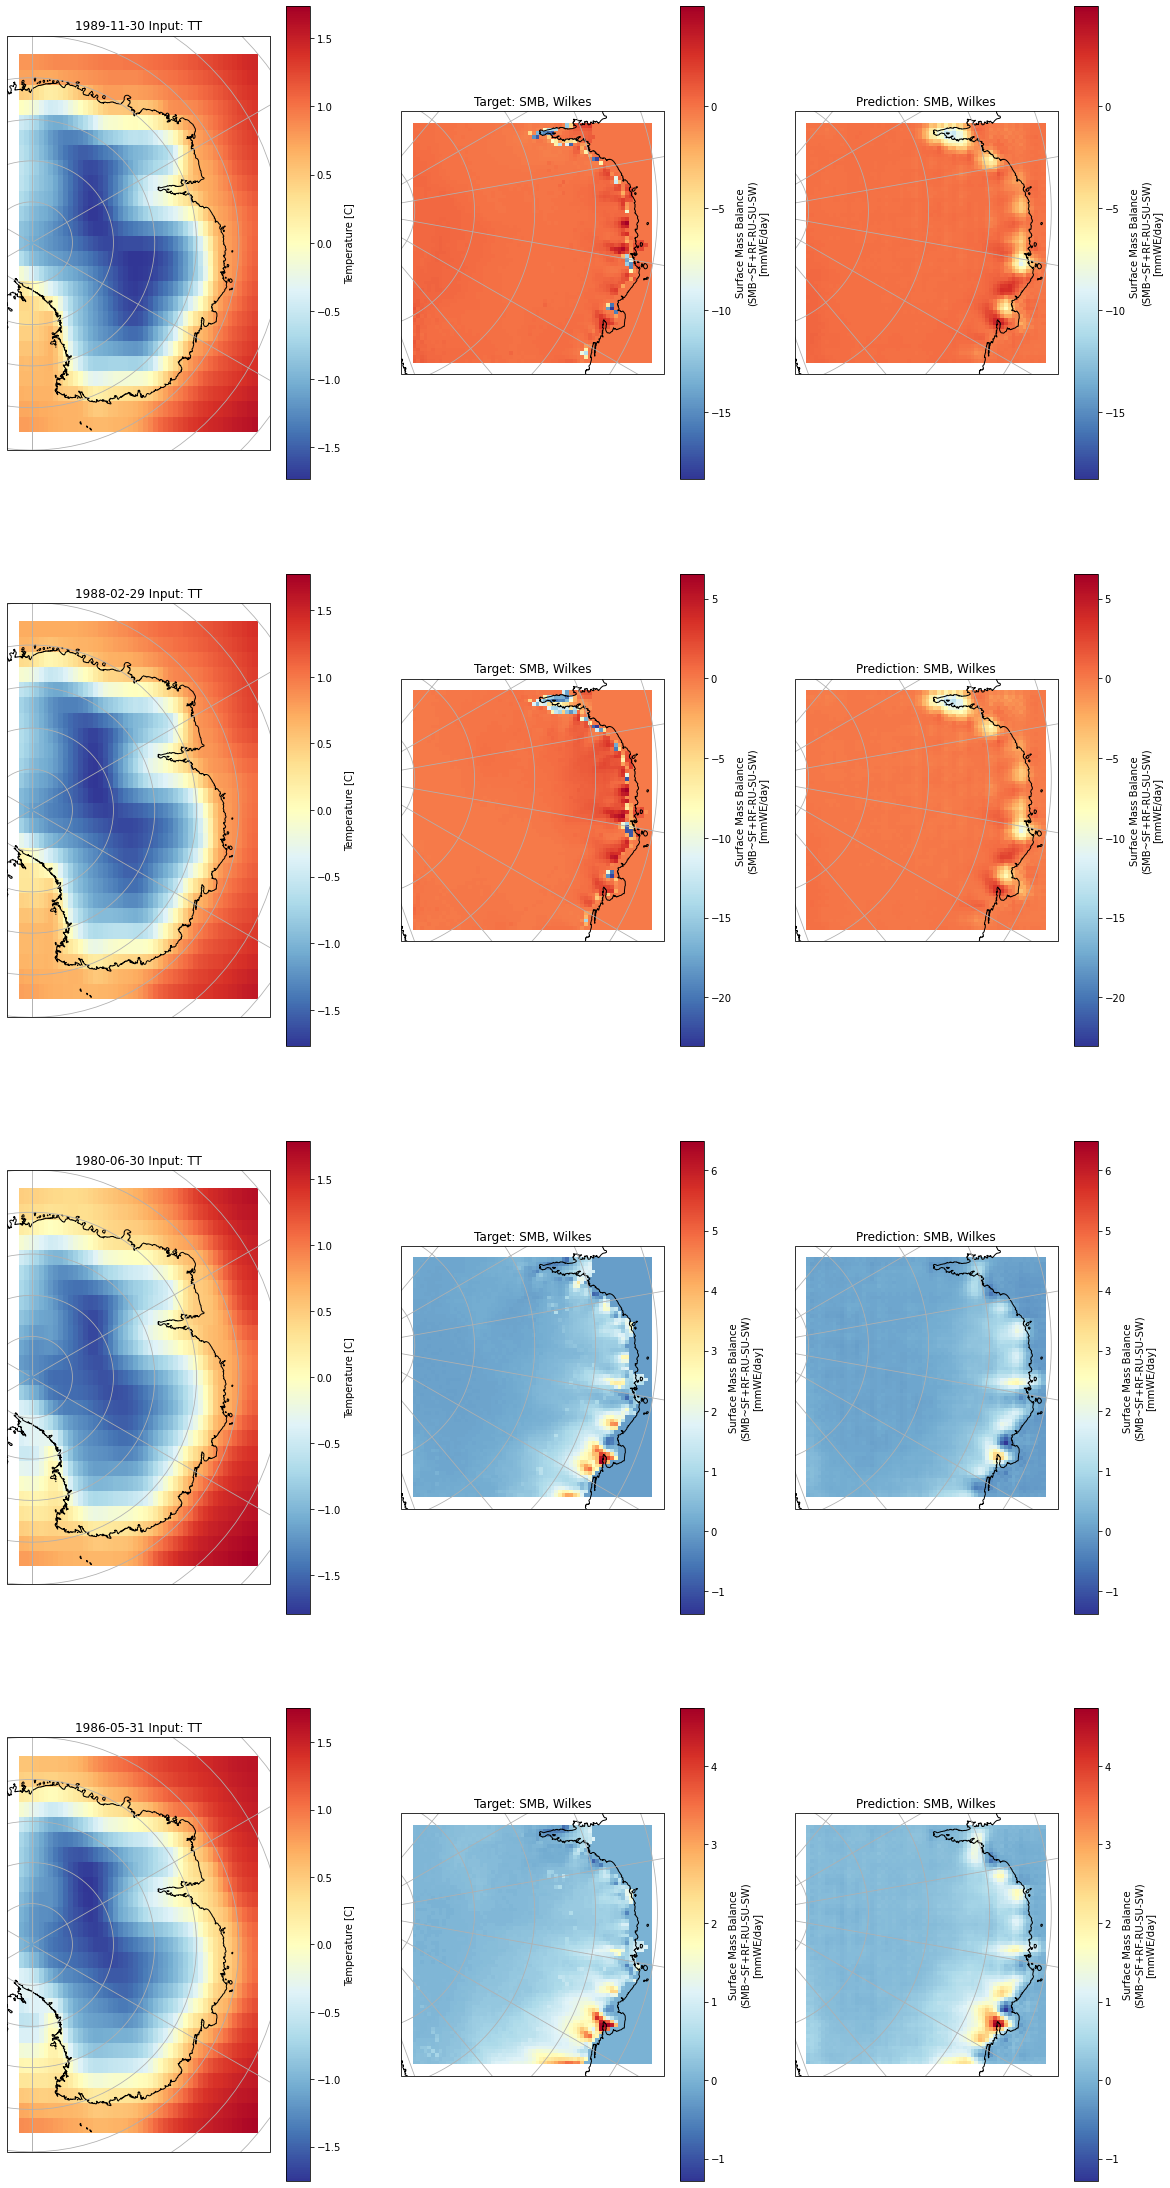

In [ ]:
# plot predictions
f = plt.figure(figsize=(20, 40))
plotRandomPredictions(
    preds_Wilkes,
    x_Wilkes,
    z_Wilkes,
    true_smb_Wilkes,
    r_Wilkes,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION]
)
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)

### Metrics:

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

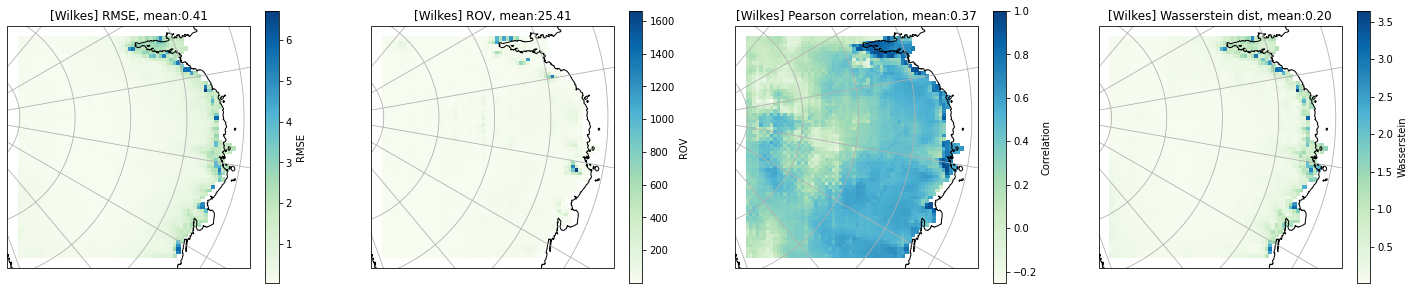

In [ ]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Wilkes, true_smb_Wilkes, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)

### Random points:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


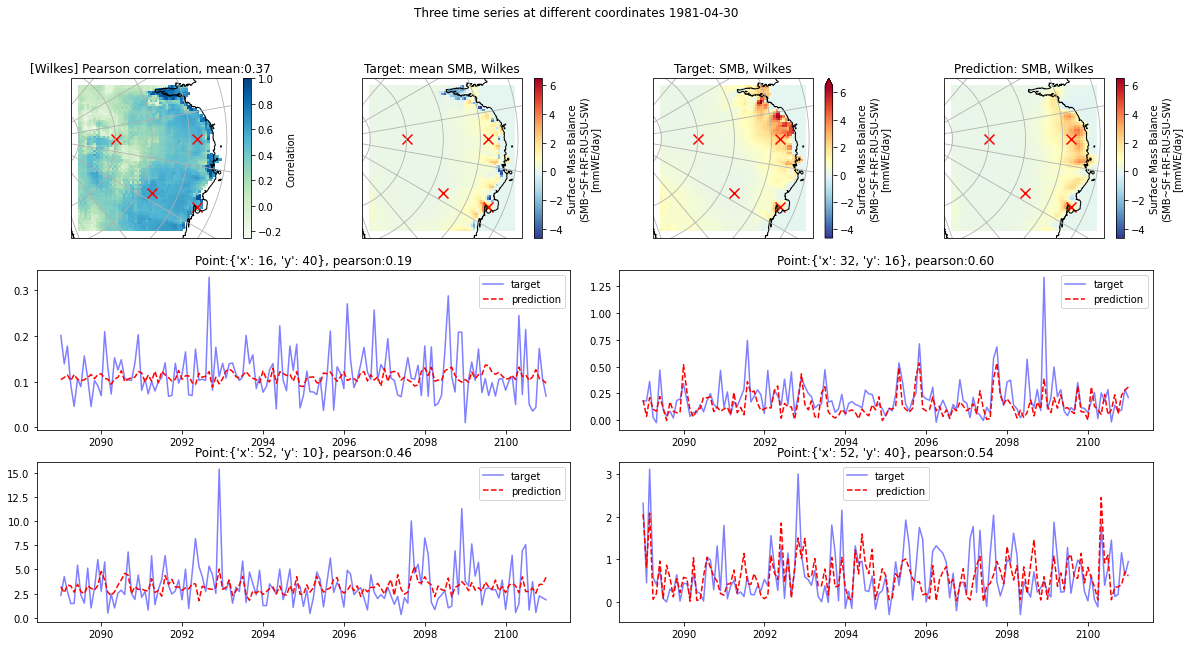

In [ ]:
# plot points
points= ({'x':16, 'y':40},{'x':32, 'y':16}, {'x':52, 'y':10}, {'x':52, 'y':40})
randomPoints(points, PearsonCorr, true_smb_Wilkes, preds_Wilkes, target_dataset, GCMLike, train_set, REGION)
nameFig = '{}_ts_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)

## Amundsen:

In [ ]:
REGION = "Amundsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss = 'MSE', 
    typeNet = 'Variance'
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, **loader_args)

# Load saved model
#today = str(date.today())
today = '2022-05-10'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    #downloadFileFromGC(pathModel, "", model)
    # Download from google drive
    idModel = '1-HpmDx4U85KLyx_hEva_d3TVEutvjaN0'
    downloaded = Googledrive.CreateFile({'id':idModel}) 
    downloaded.GetContentFile(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Am, x_Am, z_Am, true_smb_Am, r_Am = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Variance model
INFO: Network:
	14 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307



X shape: torch.Size([1452, 14, 32, 32])


INFO: Loading saved model MODEL_2022-05-10_Amundsen_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

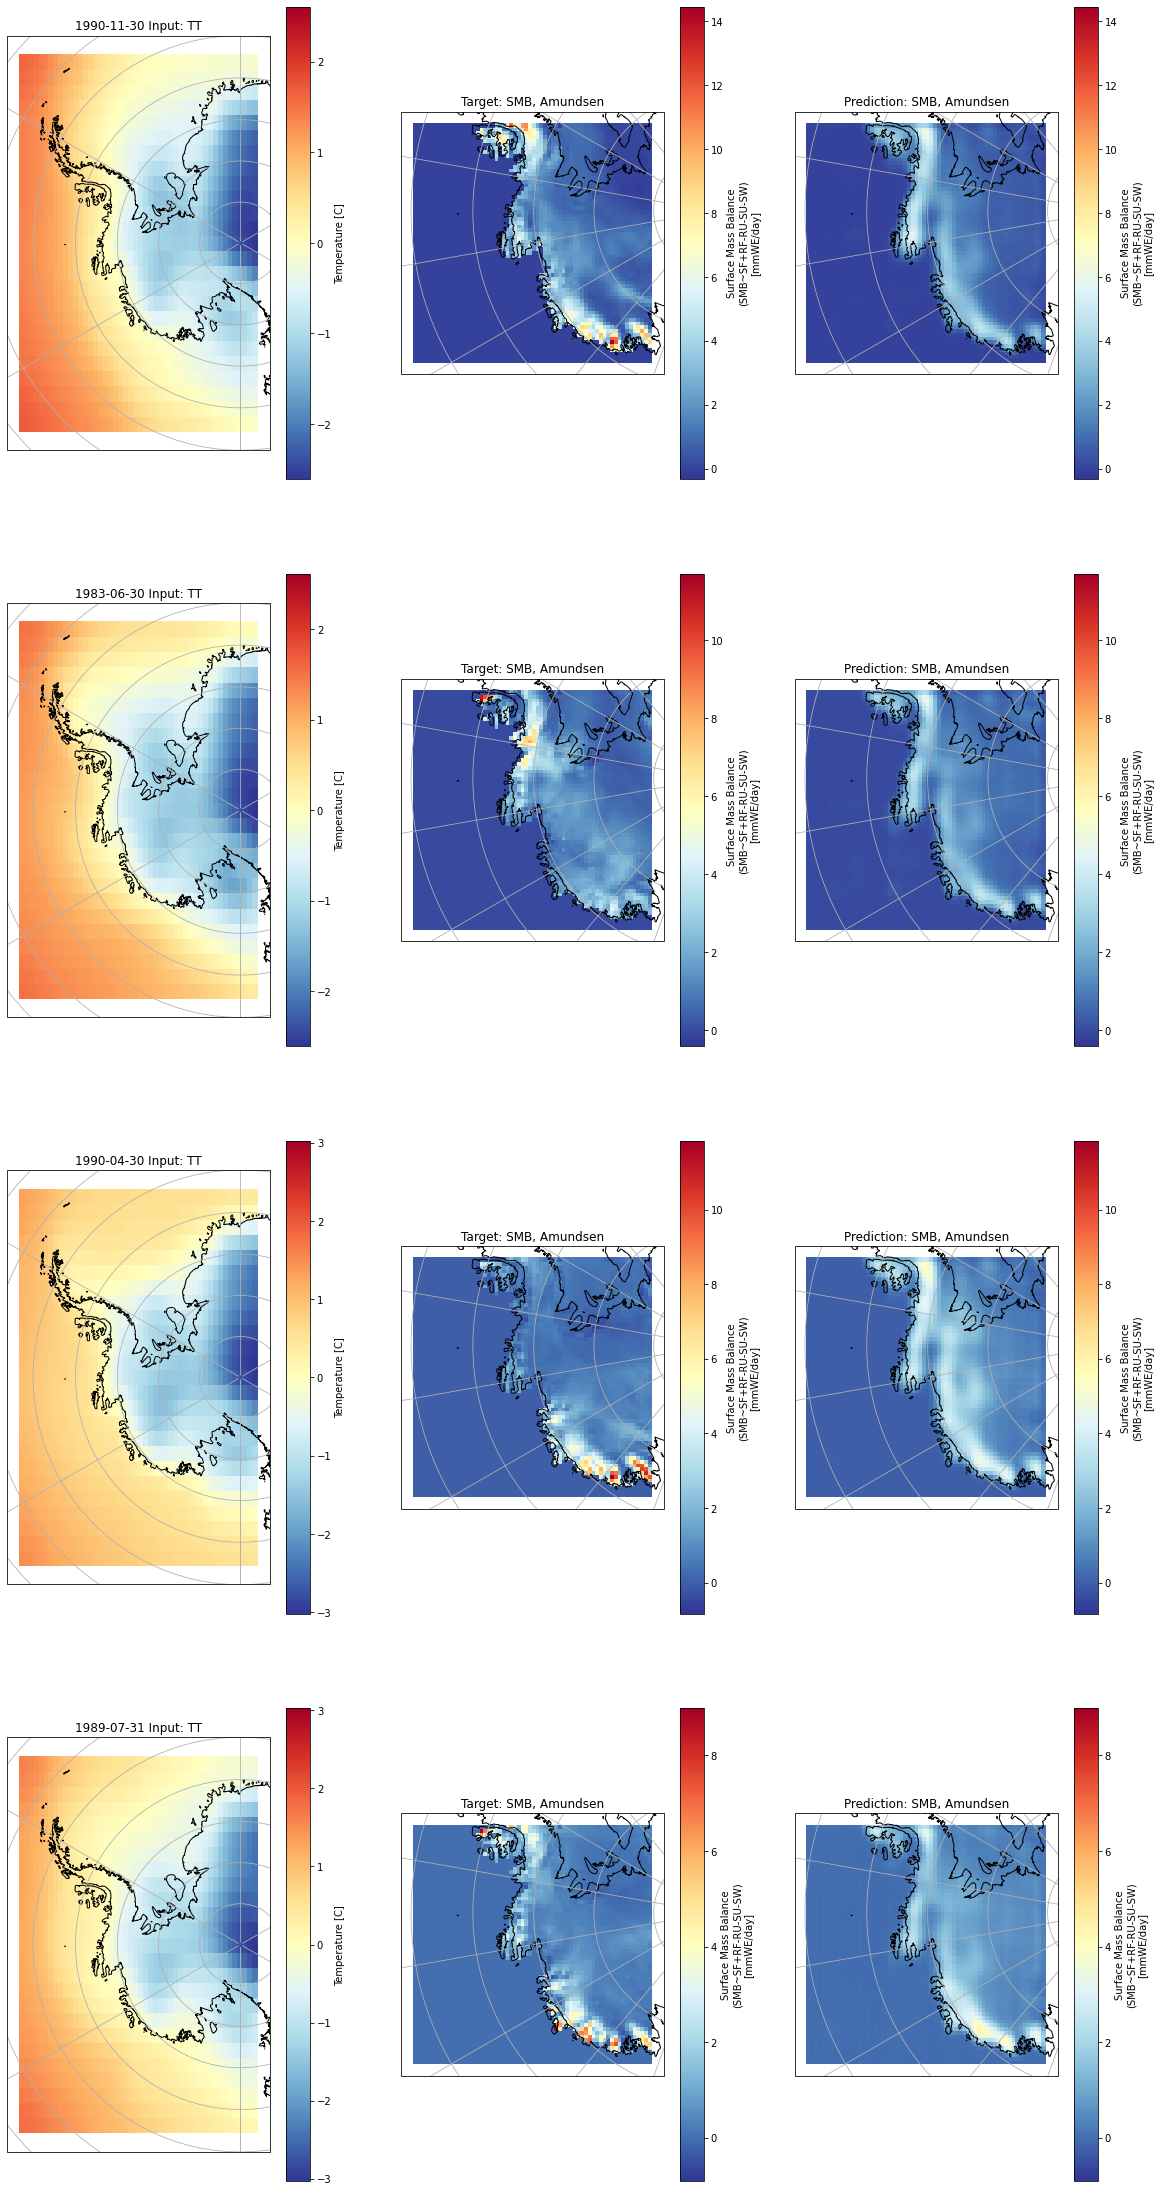

In [ ]:
# plot predictions
f = plt.figure(figsize=(20, 40))
plotRandomPredictions(
    preds_Am,
    x_Am,
    z_Am,
    true_smb_Am,
    r_Am,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION])
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)

### Metrics:

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

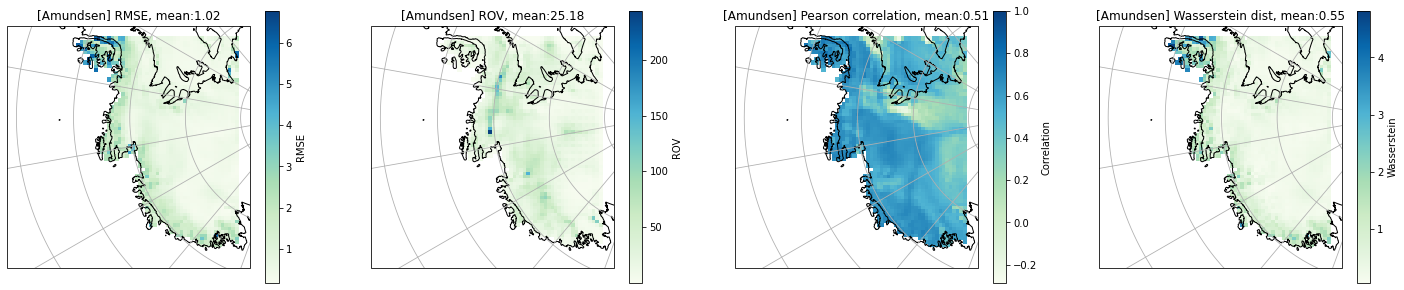

In [ ]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Am, true_smb_Am, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)

### Random points:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


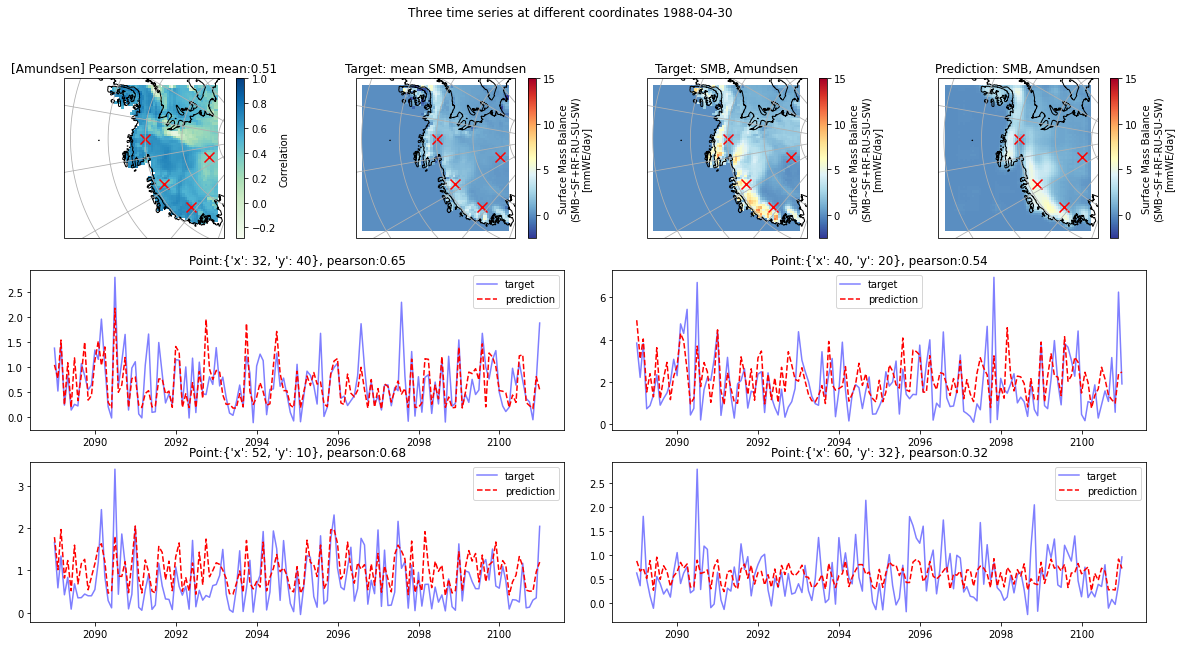

In [ ]:
# plot points
points= ({'x':32, 'y':40}, {'x':40, 'y':20}, {'x':52, 'y':10},{'x':60, 'y':32})
randomPoints(points, PearsonCorr, true_smb_Am, preds_Am, target_dataset, GCMLike, train_set, REGION)
nameFig = '{}_ts_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)

## Evaluation table:

In [ ]:
PearsonCorr_Am, Wasserstein_Am, ROV_Am, RMSE_Am = calculateMetrics(
    preds_Am, true_smb_Am, ignoreSea
)
PearsonCorr_Wilkes, Wasserstein_Wilkes, ROV_Wilkes, RMSE_Wilkes = calculateMetrics(
    preds_Wilkes, true_smb_Wilkes, ignoreSea
)
PearsonCorr_Larsen, Wasserstein_Larsen, ROV_Larsen, RMSE_Larsen = calculateMetrics(
    preds_Larsen, true_smb_Larsen, ignoreSea
)
PearsonCorr_Maud, Wasserstein_Maud, ROV_Maud, RMSE_Maud = calculateMetrics(
    preds_Maud, true_smb_Maud, ignoreSea
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: 

In [ ]:
l = [
    metricsData(Wasserstein_Larsen),
    metricsData(RMSE_Larsen),
    metricsData(ROV_Larsen),
    metricsData(PearsonCorr_Larsen),
]
df_Larsen = pd.DataFrame(l, index=["Wasserstein", "RMSE", "ROV", "Pearson"])
df_Larsen["Region"] = ["Larsen" for i in range(len(df_Larsen))]
df_Larsen = df_Larsen.reset_index()

In [ ]:
l = [
    metricsData(Wasserstein_Wilkes),
    metricsData(RMSE_Wilkes),
    metricsData(ROV_Wilkes),
    metricsData(PearsonCorr_Wilkes),
]
df_Wilkes = pd.DataFrame(l, index=["Wasserstein", "RMSE", "ROV", "Pearson"])
df_Wilkes["Region"] = ["Wilkes" for i in range(len(df_Wilkes))]
df_Wilkes = df_Wilkes.reset_index()

In [ ]:
l = [
    metricsData(Wasserstein_Am),
    metricsData(RMSE_Am),
    metricsData(ROV_Am),
    metricsData(PearsonCorr_Am),
]
df_Am = pd.DataFrame(l, index=["Wasserstein", "RMSE", "ROV", "Pearson"])
df_Am["Region"] = ["Amundsen" for i in range(len(df_Am))]
df_Am = df_Am.reset_index()

In [ ]:
l = [
    metricsData(Wasserstein_Maud),
    metricsData(RMSE_Maud),
    metricsData(ROV_Maud),
    metricsData(PearsonCorr_Maud),
]
df_Maud = pd.DataFrame(l, index=["Wasserstein", "RMSE", "ROV", "Pearson"])
df_Maud["Region"] = ["Maud" for i in range(len(df_Maud))]
df_Maud = df_Maud.reset_index()


In [ ]:
pd.concat([df_Larsen, df_Maud, df_Am, df_Wilkes]).groupby(['Region', 'index']).mean()

min       p05       mean     median        p95  \
Region   index                                                              
Amundsen Pearson     -0.285578  0.216323   0.510505   0.547445   0.695843   
         RMSE         0.182331  0.323583   1.018249   0.634469   2.730104   
         ROV          0.002819  2.097121  25.175229  20.129107  64.918172   
         Wasserstein  0.052827  0.139411   0.546757   0.310113   1.718140   
Larsen   Pearson     -0.755840  0.130288   0.473602   0.486033   0.755573   
         RMSE         0.233188  0.350982   1.563962   0.825657   4.641430   
         ROV          0.000002  0.991443  21.387565  13.484366  60.895256   
         Wasserstein  0.056342  0.127251   0.885779   0.457847   2.972047   
Maud     Pearson     -0.254923  0.083806   0.372899   0.404249   0.583190   
         RMSE         0.063971  0.090496   0.585822   0.254137   2.147179   
         ROV          0.007447  0.649805  13.202759   7.622037  44.190059   
         Wasserstein  0.032388  0.049068   0.307767   0.124865   1.150348   
Wilkes   Pearson     -0.251732  0.022933   0.366889   0.384542   0.619257   
         RMSE         0.049568  0.066928   0.406192   0.166809   1.858007   
         ROV          0.042984  0.989527  25.411497  10.931326  65.689622   
         Wasserstein  0.019029  0.037640   0.196859   0.089475   0.892267   

                              max  
Region   index                     
Amundsen Pearson         0.797762  
         RMSE            6.766315  
         ROV           243.708181  
         Wasserstein     4.814559  
Larsen   Pearson         0.854858  
         RMSE           21.524895  
         ROV           215.904260  
         Wasserstein    15.488831  
Maud     Pearson         0.693425  
         RMSE            9.149089  
         ROV           267.256880  
         Wasserstein     5.209004  
Wilkes   Pearson         0.955815  
         RMSE            6.708715  
         ROV          1659.904671  
         Wasserstein     3.642387